### Test deployed web application
This notebook pulls some images and tests them against the deployed web application.

In [17]:
from testing_utilities import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [18]:
app_url = '52.234.213.11'
app_id = '/cntkresnet'

In [19]:
scoring_url = 'http://{}/score'.format(app_url)
version_url = 'http://{}/version'.format(app_url)

Quickly check the web application is working

In [20]:
!curl $version_url # Reports the CNTK Version

2.3.1

Pull an image of a plane to test it with

In [21]:
IMAGEURL = "https://www.britishairways.com/assets/images/information/about-ba/fleet-facts/airbus-380-800/photo-gallery/240x295-BA-A380-exterior-2-high-res.jpg"

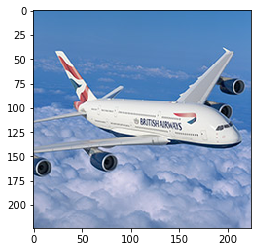

In [22]:
plt.imshow(to_img(IMAGEURL))

In [23]:
# headers = {'content-type': 'application/json','X-Marathon-App-Id': app_id}
headers = {'content-type': 'application/json'}
jsonimg = img_url_to_json(IMAGEURL)
r = requests.post(scoring_url, data=jsonimg, headers=headers) # Run the request twice since the first time takes a 
                                                              # little longer due to the loading of the model
%time r = requests.post(scoring_url, data=jsonimg, headers=headers)
r.json()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 258 ms


{'result': [[[['n02690373 airliner', 2057.77645111084],
    ['n04592741 wing', 1766.9858932495117],
    ['n04266014 space shuttle', 1649.7426986694336]]],
  'Computed in 66.95 ms']}

From the results above we can see that the model correctly classifies this as an airliner. 
The computation took around 780 ms and the whole round trip around 800 ms.

Lets try a few more images

In [24]:
images = ('https://www.britishairways.com/assets/images/information/about-ba/fleet-facts/airbus-380-800/photo-gallery/240x295-BA-A380-exterior-2-high-res.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'http://www.worldshipsociety.org/wp-content/themes/construct/lib/scripts/timthumb/thumb.php?src=http://www.worldshipsociety.org/wp-content/uploads/2013/04/stock-photo-5495905-cruise-ship.jpg&w=570&h=370&zc=1&q=100',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [25]:
results = [requests.post(scoring_url, data=img_url_to_json(img), headers=headers) for img in images]

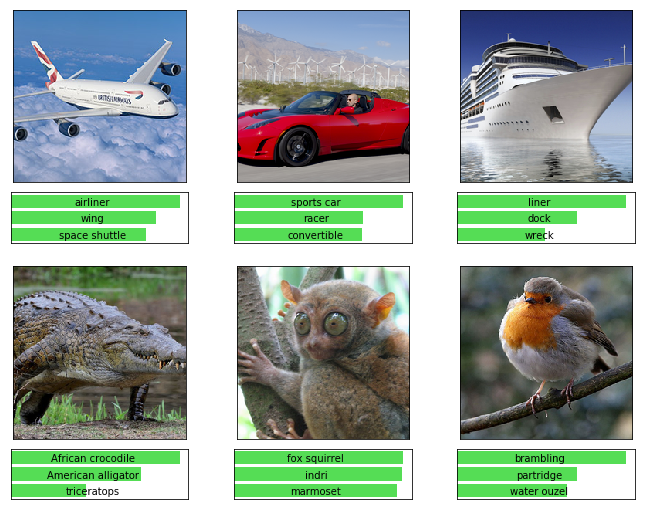

In [26]:
plot_predictions(images, results)

The results from our model look acceptable. 

Next lets quickly check what the request response performance is for the locally running Docker container.

In [27]:
image_data = list(map(img_url_to_json, images)) # Retrieve the images and data

In [28]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(scoring_url, data=img, headers=headers)
    timer_results.append(res.best)

In [29]:
timer_results

[0.24042841116897762,
 0.2038555529434234,
 0.23281388403847814,
 0.23359686019830406,
 0.26275031408295035,
 0.25918745901435614]

In [30]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 238.77 ms
